# Earth at Night from Day: Predicting Nighttime Radiance from Daytime Satellite Imagery
Isaiah Lyons-Galante  
University of Colorado Boulder



# Introduction

The imprint of human activity on Earth has become unmistakable, offering a unique vantage point for population studies through the lens of space. Access to global high-resolution datasets, such as Landsat(1), has been made possible for the public through platforms like Google Earth Engine (3). These datasets open a window to observe and analyze human settlements, providing invaluable insights into the dynamics of our changing world. The image below is from Google Earth, showing the twin cities of Brazzaville and Kishasa on the banks of the Congo River. One can clearly see the densely package settlements on the banks, along with the unpopulated islands in the river.

![brazzaville](./figs/brazzaville.png)

During the night, human presence becomes even more apparent as settlements cast a faint glow into space. This nocturnal illumination is captured by the VIIRS instrument aboard the Suomi National Polar-orbiting Partnership (NPP) satellite. Despite its significance, the relatively weak signals limit the resolution to about 500 meters squared. This limitation poses a challenge to extracting fine-grained information about the distribution and characteristics of human settlements. The image below is of the same area as the one above, but at night. The resolution is significantly lower, with the pixels clearly visible, while the island in the river is completely dark.

![brazzaville night](./figs/brazzavilleatnight.png)

Compelling research underscores the correlation between night lights and mean household wealth, as measured by ground surveys. This correlation establishes night lights as a proxy for gauging livelihoods, making them a valuable tool for socio-economic analyses. This becomes particularly crucial in regions like Sub-Saharan Africa, where traditional population surveys are sparse. The scarcity of on-the-ground data highlights the potential of night lights as a surrogate measure for understanding the economic landscapes of communities. The graph below shows the relationship between night lights and mean household wealth in Sub-Saharan Africa. The data is from the Demographic and Health Surveys (DHS) Program, which conducts household surveys in developing countries. The graph shows a clear correlation between night lights and mean household wealth.

![night lights and wealth](./figs/wealthcorrelations.jpg)

The demand for higher-resolution night lights becomes evident when considering the need for detailed impact assessments. Such assessments can unravel the intricate ways in which individual communities are affected by economic development programs or global events. As technology advances, the quest for sharper and more detailed night light data gains significance, promising to enhance our understanding of human settlements and socio-economic patterns on a global scale. One example of this comes from a paper in Nature just last year that use wealth maps to assess the economic impact of access to electricity. High resolution nightlights would open up even finer grained analysis.

![wealth map](./figs/WealthMap.png)

Embarking on this exploration of human settlements and socio-economic patterns, I employ cutting-edge methodologies to surmount the resolution challenges posed by existing night light data. Leveraging the power of machine learning, my approach involves training a model to predict night lights from high-resolution daytime imagery. By undertaking this innovative process, I aim to transcend the limitations of the existing data and generate high-resolution nighttime imagery. This fusion of technological advancements with geospatial analysis not only promises to enrich our understanding of human settlements but also sets the stage for a more nuanced examination of the impact of economic development programs and global events on individual communities. This notebook will serve as a guide for the entire process, from method design to model training and evaluation, and finally, the results and conclusions. The code is available on [GitHub](https://github.com/isaiahlg/csci5922/blob/main/proj/unet_regression_virrs.ipynb).



# Methods
Because I are trying to predict one image from another, I can leverage a Fully Convolutional Network (6) with no dense layers. This allow us to use input imagery of any resolution. The U-Net (7) architecture, named for the shape of the diagram, is the most popular FCN and is well suited to our task. The output layer is modified to perform regression instead of classification so that I get a continuous radiance value instead of segment class. Below is a diagram of U-Net from the original paper -- notice the distintive U shape.

![unet](./figs/unet.png)

With the model in place, I then need to define our training data. In this project, four different training datasets were tested: both large training regions with 1000 image patch samples from each, as well as small regions with 100 image patch samples from each. Each of these were pulled from the United States and the African continent.  For each, there were 8 unique training regions, and 2 evaluation regions. For both areas, the polygons were centered around urban areas, as these have the greatest range of values in nighttime radiance. For consistency, the evaluation areas were also urban areas. Because the target is to predict nightlights in under-surveyed areas, the evaluation sites were Abuja, Nigeria, and Nairobi, Kenya. On the left, I have the large image patches from North America, and on the right from the African. Training patches are in yellow, and evaluation regions are in blue. The aim of having different continents as inputs was to test how transferrable the results are. Do well-lit areas in the US look like well-lit areas in Africa? 

American Cities             |  African Cities
:-------------------------:|:-------------------------:
![](./figs/usatrain.png)  |  ![](./figs/africatrain.png)


For daytime imagery inputs, I pulled 9 bands from Landsat, 7 optical bands and 2 thermal bands. I created a cloud-masked image composite to create high-quality, cloud free input. For nightlight output, I also create a median composite of the average radiance band from stray-light corrected nightlights.8 The aim is that by pairing each daytime image patch of 256 x 256 with the corresponding nighttime image patch, I can predict nighttime image patches of 128x128 when the original resolution was about 16x16. This is almost 60X improvement in resolution.  Below on the left, I have a set of example input images from Landsat in false-color. The level of detail is significant compared with the coarse nightlight image patches on the right. 

Sample Training Inputs            |  Sample Training Labels
:-------------------------:|:-------------------------:
![](./figs/trainpatches.png)  |  ![](./figs/labelpatches.png)

The other parameters that were experimented with were the number of epochs and the optimizer algorithm. For epochs, values between 1 and 50 were tried for most models. For the optimizer, a single experiment was run with one of the top performing models to see how it would compare. The imagery was compiled in Google Earth Engine via their Python API (9), exported to a Linux computer with a 48GB GPU. The model was built with tensorflow (10), code is available on GitHub (11).


# Code for Implementing the Model

Below are the chunks of code to gather the data. To run it yourself, copy and paste the .env.example file to .env and fill in your own file paths and Google Earth Engine credentials. You need an account on Google Cloud Platform with Storage Buckets and access to the Google Earth Engine API to run this, but it can be adapted to export to Google Drive instead before copying it locally.

## Configure the Environment

In [1]:
# Read in the .env file
from dotenv import dotenv_values, load_dotenv

# load env variables
config = dotenv_values(".env")
load_dotenv()

# set env variables
GCS_PROJECT = config['GCS_PROJECT']
BUCKET = config['BUCKET']
HOME_PATH = config['HOME_PATH']
LOCAL_PATH = config['LOCAL_PATH']
DATA_PATH = config['DATA_PATH']
FOLDER = config['FOLDER']
GCLOUD_PATH = config['GCLOUD_PATH']
DEVICE = config['DEVICE']
CUDA_VISIBLE_DEVICES = config['CUDA_VISIBLE_DEVICES']
GPU_MEMORY_LIMIT = int(config['GPU_MEMORY_LIMIT'])
GPU_MEMORY_CAPACITY = int(config['GPU_MEMORY_CAPACITY'])

print(config)


OrderedDict([('GCS_PROJECT', 'phd-isaiah'), ('BUCKET', 'viirs-africa-huge/'), ('HOME_PATH', '/Users/isaiah/'), ('LOCAL_PATH', '/ADrive/data/'), ('DATA_PATH', '/data/'), ('FOLDER', 'unet-viirs/'), ('GCLOUD_PATH', '/Users/isaiah/google-cloud-sdk/bin/gcloud'), ('DEVICE', 'mps'), ('CUDA_VISIBLE_DEVICES', '0'), ('GPU_MEMORY_LIMIT', '16000'), ('GPU_MEMORY_CAPACITY', '24000')])


## Import Key Libraries and Authenticate to Google Earth Engine

We use Earth Engine to fetch, process, and display our imagery. We use tensorflow to build and train our model. Finally, we use folium to create interactive maps to display our results.

In [2]:
# Import, authenticate and initialize the Earth Engine library.
import ee
ee.Authenticate()
ee.Initialize()

# Tensorflow setup.
# import tensorflow as tf
# print(tf.__version__)

# supress warnings
import warnings
warnings.filterwarnings('ignore')

import geemap

## Set other Global Variables

In [3]:
# variables for image names
TRAINING_BASE = 'training_patches'
EVAL_BASE = 'eval_patches'

# Specify inputs (Landsat bands) to the model and the response variable.
opticalBands = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']
thermalBands = ['ST_B10']
BANDS = opticalBands + thermalBands
RESPONSE = 'avg_rad' ##### 
FEATURES = BANDS + [RESPONSE]

# Specify the size and shape of patches expected by the model.
# KERNEL_SIZE = 256
# KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]
# COLUMNS = [
#   tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in FEATURES
# ]
# FEATURES_DICT = dict(zip(FEATURES, COLUMNS))

# Sizes of the training and evaluation datasets.
# TRAIN_SIZE = 4800
# EVAL_SIZE = 200

# # Specify model training parameters.
# BATCH_SIZE = 48 ## TODO change to power of 2 (32)
# EPOCHS = 1
# BUFFER_SIZE = 2000
# OPTIMIZER = 'SGD' ## TODO: change to Adam
# LOSS = 'MeanSquaredError'
# METRICS = ['RootMeanSquaredError']

# Data Preparation

Gather and setup the imagery to use for inputs (predictors).  This is a three-year, cloud-free, Landsat 8 composite.  Display it in the notebook for a sanity check.

In [4]:
## Landsat

l8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterDate('2020-01-01', '2020-12-31')

# Apply scaling factors.
def apply_scale_factors(image):
  optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
  return image.addBands(optical_bands, None, True).addBands(
      thermal_bands, None, True
)
l8 = l8.map(apply_scale_factors)

# Cloud mask function using QA_PIXEL band
def mask_clouds(image):
    qa = image.select('QA_PIXEL')
    cloud_mask = qa.bitwiseAnd(1 << 3).eq(0)  # Keep only non-cloudy pixels
    return image.updateMask(cloud_mask)
l8 = l8.map(mask_clouds).median()


l8_vis = {
    'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
    'min': 0.0,
    'max': 0.3,
}

## VIIRS

viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG") \
    .select('avg_rad') \
    .filterDate('2020-01-01', '2020-12-31') \
    .median()


## Sentinel-2

def mask_s2_clouds(image):
  """Masks clouds in a Sentinel-2 image using the QA band.

  Args:
      image (ee.Image): A Sentinel-2 image.

  Returns:
      ee.Image: A cloud-masked Sentinel-2 image.
  """
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )

  return image.updateMask(mask).divide(10000)

s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterDate('2020-01-01', '2020-12-31') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
    .map(mask_s2_clouds) \
    .median()

s2_vis = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B4', 'B3', 'B2'],
}

m = geemap.Map()
m.set_center(83.277, 17.7009, 12)
m


## Visualize

m = geemap.Map()
m.set_center(-74, 40.7, 10)
m.add_layer(l8, l8_vis, 'Landsat 8')
m.add_layer(s2, s2_vis, 'Sentinel-2')
m.add_layer(viirs, {'min': 0.0, 'max': 90.0, 'alpha':0.5}, 'VIIRS DNB')
m

Map(center=[40.7, -74], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(c…

## Bring in a High Resolution Image for Comparison
This is a 10-meter resolution nighttime image of New York City from 2020.

In [5]:
viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG") \
    .select('avg_rad') \
    .filterDate('2020-01-01', '2020-12-31') \
    .median()

nyc_image_path = '/Users/isaiah/data/unet-viirs/iss/nyc/ISS064-E-40613.tif'
m = geemap.Map(height='1000px')
m.set_center(-74, 40.7, 10)
m.add_layer(s2, s2_vis, 'Sentinel-2')
m.add_layer(viirs, {'min': 0.0, 'max': 100.0}, 'VIIRS DNB', opacity=0.5)
# geemap.Map.add_raster documentation: https://github.com/gee-community/geemap/blob/6f17eba218ffa40a89a9803cb83c3d47ff6b032b/geemap/geemap.py#L2468
m.add_raster(nyc_image_path, colormap='gray', layer='NYC', opacity=0.4)
m

Map(center=[40.7, -74], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(c…

## Convert the High-Res Image from RGB to Panchromatic
This is a 10-meter resolution nighttime image of New York City from 2020. Let's start by opening and visualizing it and its metadata.

To convert this RGB image to a panchromatic image, we need to combine the red, green, and blue channels into a single grayscale value. There are several methods to do this, each with its own advantages and disadvantages. Here are three common methods:

#### Method 1: Standard Grayscale Conversion (Luminosity)
A quick approach is to use the perceptual grayscale conversion, which mimics human brightness perception:
$$
I_{\text{gray}} = 0.2989 \cdot R + 0.5870 \cdot G + 0.1140 \cdot B\
$$
This works but does not perfectly match VIIRS DNB because it prioritizes human vision, whereas DNB is more sensitive to near-infrared (NIR) light.

#### Method 2: Weighted Panchromatic Approximation
If you want a better match to VIIRS DNB, assign weights that better reflect nighttime light sensitivity. VIIRS DNB is particularly responsive to longer wavelengths, so you may want to emphasize the red and green channels more:

$$
I_{\text{panchro}} = 0.25 \cdot R + 0.65 \cdot G + 0.10 \cdot B
$$
This accounts for the broader sensitivity of VIIRS, which leans towards the near-infrared spectrum.

#### Method 3: Histogram Matching to VIIRS DNB
Since we have a reference VIIRS DNB image of the same scene, we can apply histogram matching to adjust the intensity distribution of the converted image to match the DNB characteristics.
Documentation on a function to do this here: https://scikit-image.org/docs/0.24.x/auto_examples/color_exposure/plot_histogram_matching.html#histogram-matching
Example on how to do this with Earth Engine: https://developers.google.com/earth-engine/tutorials/community/histogram-matching
#### Aproach: 
Let's use Method 2, and revisit the possibility of Method 3 later.

CRS is EPSG:4326
Bounds are BoundingBox(left=-74.12669190803139, bottom=40.53746128375234, right=-73.79032111196614, top=40.917524302063235)
Shape is (3712, 5568)
Transform is |-0.00,-0.00,-73.79|
|-0.00, 0.00, 40.91|
| 0.00, 0.00, 1.00|
No data is None
Driver is GTiff
Dtype is ('uint8', 'uint8', 'uint8')
Width is 5568
Height is 3712
Channel count is 3
Block shapes are [(1, 5568), (1, 5568), (1, 5568)]
Indexes are (1, 2, 3)
Metadata is {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 5568, 'height': 3712, 'count': 3, 'crs': CRS.from_epsg(4326), 'transform': Affine(-3.7784471535374796e-06, -8.494946183037501e-05, -73.79032111196614,
       -6.682465372474706e-05, 2.1506859837023132e-06, 40.90954095569173)}
Tags are {'AREA_OR_POINT': 'Area'}


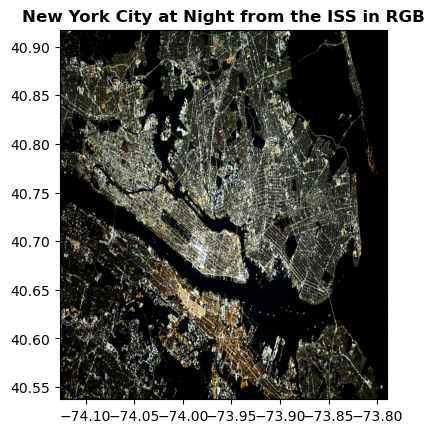

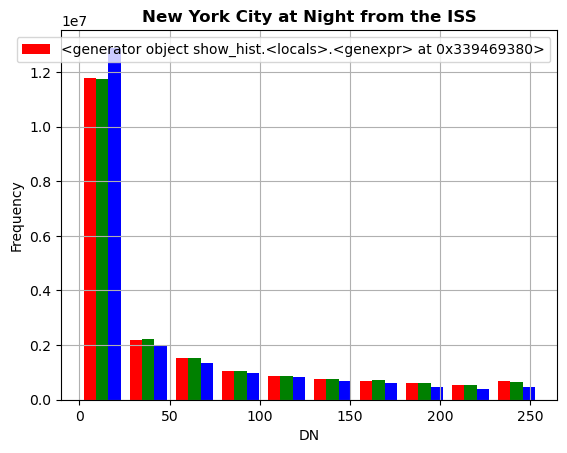

Metadata is {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 5568, 'height': 3712, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(-3.7784471535374796e-06, -8.494946183037501e-05, -73.79032111196614,
       -6.682465372474706e-05, 2.1506859837023132e-06, 40.90954095569173)}


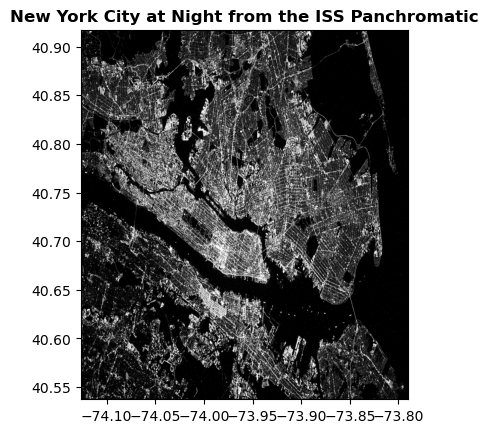

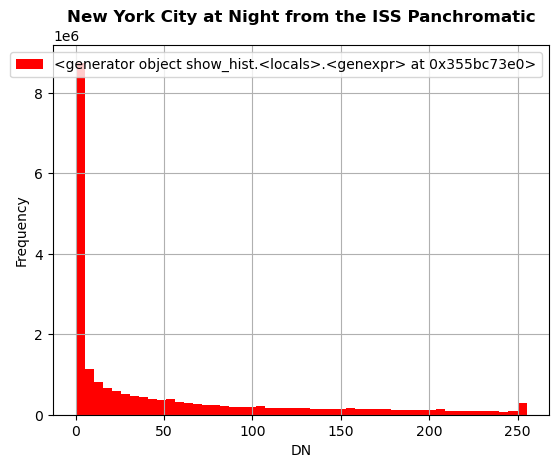

In [25]:
import rasterio
import rasterio.plot
import numpy as np

nyc_image_path = '/Users/isaiah/data/unet-viirs/iss/nyc/ISS064-E-40613.tif'
nyc_panchro_path = '/Users/isaiah/data/unet-viirs/iss/nyc/ISS064-E-40613-panchro.tif'

nyc = rasterio.open(nyc_image_path)
print("CRS is", nyc.crs)
print("Bounds are", nyc.bounds)
print("Shape is", nyc.shape)
print("Transform is", nyc.transform)
print("No data is", nyc.nodata)
print("Driver is", nyc.driver)
print("Dtype is", nyc.dtypes)
print("Width is", nyc.width)
print("Height is", nyc.height)
print("Channel count is", nyc.count)
print("Block shapes are", nyc.block_shapes)
print("Indexes are", nyc.indexes)
print("Metadata is", nyc.meta)
print("Tags are", nyc.tags())
rasterio.plot.show(nyc, title = "New York City at Night from the ISS in RGB")
rasterio.plot.show_hist(nyc, title = "New York City at Night from the ISS")

# multiple each band times a weight and sum to create panchromatic image
nyc_panchro = 0.25 * nyc.read(1) + 0.65 * nyc.read(2) + 0.1 * nyc.read(3)
nyc_panchro = np.clip(nyc_panchro, 0, 255).astype(np.uint8)
# copy over metadata from RGB image to panchro image
nyc_panchro_meta = nyc.meta.copy()
nyc_panchro_meta.update({
    'count': 1,
})
# write panchromatic image to disk
with rasterio.open(nyc_panchro_path, 'w', **nyc_panchro_meta) as dst:
    dst.write(nyc_panchro, 1)

# open panchromatic image from disk
nyc_panchro = rasterio.open(nyc_panchro_path)
print("Metadata is", nyc_panchro.meta)
rasterio.plot.show(nyc_panchro, cmap = 'gray', title = "New York City at Night from the ISS Panchromatic")
rasterio.plot.show_hist(nyc_panchro, bins=50, title = "New York City at Night from the ISS Panchromatic")

# close images
nyc.close()
nyc_panchro.close()

## Export a GeoTIFF of the VIIRS DNB Image
Now that we have our high-resolution panchromatic image, we want the equivalent low-resolution VIIRS DNB image. We can use the Earth Engine API to export this as a GeoTIFF so that we can compare it at a pixel level.

In [ ]:
viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG") \
    .select('avg_rad') \
    .filterDate('2020-01-01', '2020-12-31') \
    .median()
print("VIIRS is", viirs.getInfo())

# read in the raster
nyc_image_path = '/Users/isaiah/data/unet-viirs/iss/nyc/ISS064-E-40613.tif'
m = geemap.Map(height='500px')
m.set_center(-74, 40.7, 10)
m.add_layer(viirs, {'min': 0.0, 'max': 100.0}, 'VIIRS DNB')
# geemap.Map.add_raster documentation: https://github.com/gee-community/geemap/blob/6f17eba218ffa40a89a9803cb83c3d47ff6b032b/geemap/geemap.py#L2468
m.add_raster(nyc_panchro_path, colormap='gray', layer='NYC', opacity=0.4)

# get the bounds of the raster image
nyc_panchro = rasterio.open(nyc_panchro_path)
print("Metadata is", nyc_panchro.meta)
bounds = nyc_panchro.bounds
transform = nyc_panchro.transform
# calculate where the corners of the image are in lat/lon using transforms
upper_left = transform * (0, 0)
upper_right = transform * (nyc_panchro.width, 0)
lower_left = transform * (0, nyc_panchro.height)
lower_right = transform * (nyc_panchro.width, nyc_panchro.height)

# define the bounding box for the image
bbox = ee.Geometry.LinearRing([
    [upper_left[0], upper_left[1]],
    [upper_right[0], upper_right[1]],
    [lower_right[0], lower_right[1]],
    [lower_left[0], lower_left[1]],
    [upper_left[0], upper_left[1]]
])

# add box to the map
m.addLayer(bbox, {}, 'Bounding Box')

# metadata from the raster
# 'crs': CRS.from_epsg(4326), 'transform': Affine(-3.7784471535374796e-06, -8.494946183037501e-05, -73.79032111196614,
#    -6.682465372474706e-05, 2.1506859837023132e-06, 40.90954095569173)}

# export the clipped image to geotiff locally
task = ee.batch.Export.image.toDrive(
    image=viirs,
    description='nyc_viirs_v4_10m',
    folder='NightlightsV2',
    region=bbox,
    fileFormat='GeoTIFF',
    crs='EPSG:4326',
    scale=10 # use this line or the one below
    # crsTransform=[-3.778447e-06, -8.494946e-05, -73.790321, -6.682465e-05, 2.150686e-06, 40.909541],
)
task.start()

m

VIIRS is {'type': 'Image', 'bands': [{'id': 'avg_rad', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}]}
Metadata is {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 5568, 'height': 3712, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(-3.7784471535374796e-06, -8.494946183037501e-05, -73.79032111196614,
       -6.682465372474706e-05, 2.1506859837023132e-06, 40.90954095569173)}


Map(center=[40.7, -74], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(c…

## Histogram Match
Read in exported VIIRS image, and histogram match it to the high-res image.

Metadata is {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 5568, 'height': 3712, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(-3.7784471535374796e-06, -8.494946183037501e-05, -73.79032111196614,
       -6.682465372474706e-05, 2.1506859837023132e-06, 40.90954095569173)}


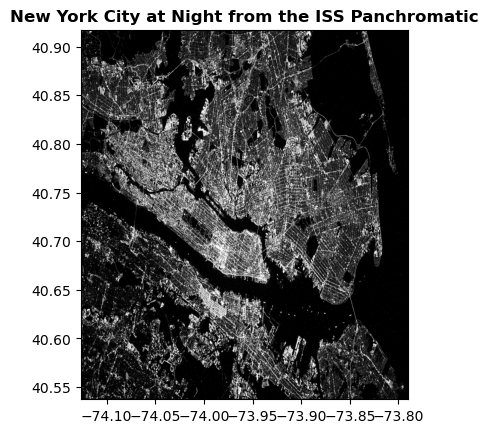

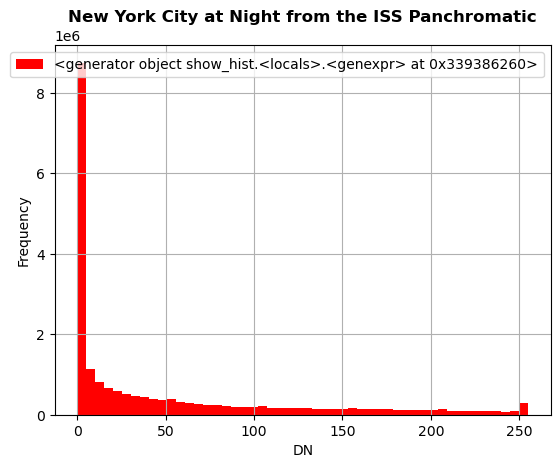

Metadata is {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 3745, 'height': 4232, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(8.983152841195215e-05, 0.0, -74.12673145733261,
       0.0, -8.983152841195215e-05, 40.91754253941691)}


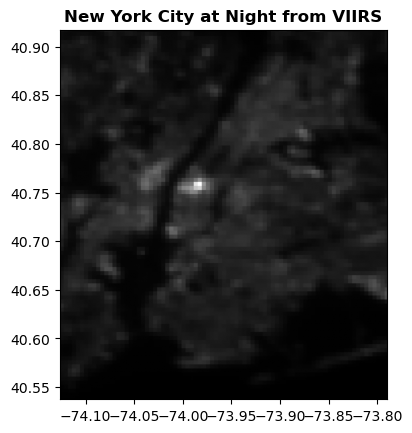

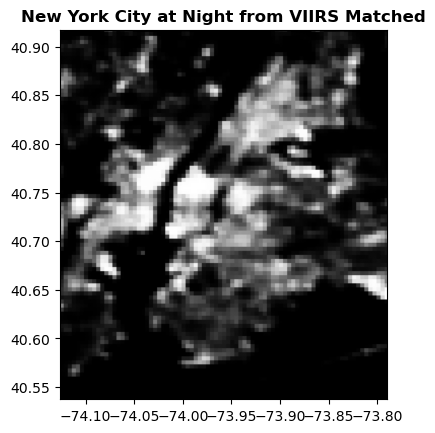

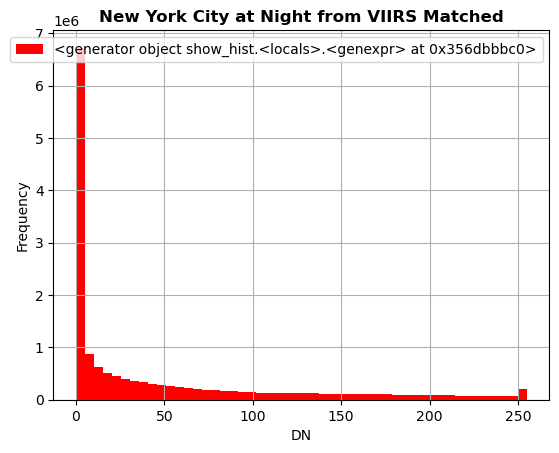

Metadata is {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 3745, 'height': 4232, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(8.983152841195215e-05, 0.0, -74.12673145733261,
       0.0, -8.983152841195215e-05, 40.91754253941691)}


In [34]:
nyc_panchro_path = '/Users/isaiah/data/unet-viirs/iss/nyc/ISS064-E-40613-panchro.tif'
nyc_viirs_path = '/Users/isaiah/data/unet-viirs/iss/nyc/nyc_viirs_v4_10m.tif'

# open panchromatic image from disk
nyc_panchro = rasterio.open(nyc_panchro_path)
print("Metadata is", nyc_panchro.meta)
rasterio.plot.show(nyc_panchro, cmap = 'gray', title = "New York City at Night from the ISS Panchromatic")
rasterio.plot.show_hist(nyc_panchro, bins = 50, title = "New York City at Night from the ISS Panchromatic")

# open the viirs image from disk
nyc_viirs = rasterio.open(nyc_viirs_path)
print("Metadata is", nyc_viirs.meta)
rasterio.plot.show(nyc_viirs, cmap = 'gray', title = "New York City at Night from VIIRS")
# viirs historgram


# scale the viirs image to 0-255
nyc_viirs_scaled = (nyc_viirs.read(1) - nyc_viirs.read(1).min()) / (nyc_viirs.read(1).max() - nyc_viirs.read(1).min()) * 255
nyc_viirs_scaled = np.clip(nyc_viirs_scaled, 0, 255).astype(np.uint8)

# match the histogram of the viirs image to the panchromatic image
from skimage import exposure
nyc_viirs_matched = exposure.match_histograms(nyc_viirs.read(1), nyc_panchro.read(1))
# copy over metadata from viirs image to matched image
nyc_viirs_matched_meta = nyc_viirs.meta.copy()
nyc_viirs_matched_meta.update({
    'count': 1,
})
# write matched image to disk
with rasterio.open('/Users/isaiah/data/unet-viirs/iss/nyc/nyc_viirs_matched.tif', 'w', **nyc_viirs_matched_meta) as dst:
    dst.write(nyc_viirs_matched, 1)
# reread from disk
nyc_viirs_matched = rasterio.open('/Users/isaiah/data/unet-viirs/iss/nyc/nyc_viirs_matched.tif')
rasterio.plot.show(nyc_viirs_matched, cmap = 'gray', title = "New York City at Night from VIIRS Matched")
rasterio.plot.show_hist(nyc_viirs_matched, bins = 50, title = "New York City at Night from VIIRS Matched")
print("Metadata is", nyc_viirs_matched.meta)
# close images
nyc_panchro.close()
nyc_viirs.close()
nyc_viirs_matched.close()

## To Do's
[ ] Need to align the images spatially with the same transforms
- Either reexport the GeoTIFF from GEE with the same transform as the high-res image
- Or use gdalwarp to reproject the high-res image to match the VIIRS image

[ ] Need to get a distribution of the high res pixel values underneath each of the coarse VIIRS pixels
- Plot the distribution of values as a function of the VIIRS pixel value
- See what shape the distribution has
- See what happens if you log transform or sqrt it
- See what type of distibution it is (gaussian, lognormal, poisson, etc)
[ ] Repeat for other ISS images


[ ] Should I try an inequality metic just with the hi-res images, overlaid with hi-res population?
- Check with Tammy to see if these high res nighttime images are helpful